In [1]:
#install PyG in google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz

import numpy as np
import torch as th
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from pyg_classifier.data import CGDataset


print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 3

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt"
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k)

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k)

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k)

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k)

Pytorch Version 1.10.2
Cuda is available: True
Using device: cuda


In [9]:
import torch_geometric.utils as pygu
import networkx as nx
print(training_dataset)
print(training_dataset[0])
print(training_dataset.data.x.shape)
print(training_dataset.data.is_undirected())
print(len(training_dataset))
print(training_dataset[1].num_nodes)
print(training_dataset[1].y)
#print(training_dataset[1].adj)
#print(pygu.to_dense_adj(training_dataset[0].edge_index))#to_scipy_sparse_matrix(training_dataset[0].edge_index))
#g = pygu.convert.to_networkx(training_dataset[1].adj,node_attrs=training_dataset[0].x, edge_attrs=None, to_undirected=True )
#nx.draw(g)
print(max([t.num_nodes for t in training_dataset]))


CGDataset(760)
Data(x=[12, 15], edge_index=[2, 26], y=[1], name='5jb3_4_tRNA_4_rn37.cg')
torch.Size([11769, 15])
True
760
12
tensor([15.9000])
22


TODO:
*  

In [2]:
#Model
import torch.nn.functional as F
import torch_geometric.nn as tgnn

#Coarse Grain RNA Classifier Model
class CG_Classifier(th.nn.Module):
    def __init__(self, num_node_feats):
        self.num_node_feats = num_node_feats
        self.c = 0
        super(CG_Classifier, self).__init__()
        
        self.conv1 = tgnn.TAGConv(self.num_node_feats, 64, K=2)
        self.norm1 = th.nn.LayerNorm(64)
        self.conv2 = tgnn.TAGConv(64, 64, K=2)
        self.norm2 = th.nn.LayerNorm(64)
        self.conv3 = tgnn.TAGConv(64, 64, K=2)
        self.norm3 = th.nn.LayerNorm(64)
        self.conv4 = tgnn.TAGConv(64, 64, K=2)
        self.norm4 = th.nn.LayerNorm(64)
        self.conv5 = tgnn.TAGConv(64, 32, K=2)
        self.norm5 = th.nn.LayerNorm(32)

        self.sage_conv1 = tgnn.SAGEConv(32, 32)
        self.norm6 = th.nn.LayerNorm(32)
        self.sage_conv2 = tgnn.SAGEConv(32, 32)
        self.norm7 = th.nn.LayerNorm(32)
        self.sage_conv3 = tgnn.SAGEConv(32, 32)
        self.norm8 = th.nn.LayerNorm(32)
        self.sage_conv4 = tgnn.SAGEConv(32, 32)
        self.norm9 = th.nn.LayerNorm(32)
        self.sage_conv5 = tgnn.SAGEConv(32, 32)
        self.norm10 = th.nn.LayerNorm(32)
        
        self.classify = th.nn.Sequential(
            th.nn.Linear(32, 256),# 512),
            th.nn.ELU(),
            th.nn.Linear(256, 256), #(512, 512),
            th.nn.ELU(),
            th.nn.Linear(256, 256), #(512, 512),
            th.nn.ELU(),
            th.nn.Linear(256, 256), #(512, 512),
            th.nn.ELU(),
            th.nn.Linear(256, 1) #(512, 1)
        )

        self.pos = th.nn.ReLU()
        
    def forward(self, data, training=False):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        x = self.conv1(x, edge_index)
        x = F.elu(self.norm1(x))
        x = self.conv2(x, edge_index)
        x = F.elu(self.norm2(x))
        x = self.conv3(x, edge_index)
        x = F.elu(self.norm3(x))
        x = self.conv4(x, edge_index)
        x = F.elu(self.norm4(x))
        x = self.conv5(x, edge_index)
        x = F.elu(self.norm5(x))

        
        x = self.sage_conv1(x, edge_index)
        x = F.elu(self.norm6(x))
        x = self.sage_conv2(x, edge_index)
        x = F.elu(self.norm7(x))
        x = self.sage_conv3(x, edge_index)
        x = F.elu(self.norm8(x))
        x = self.sage_conv4(x, edge_index)
        x = F.elu(self.norm9(x))
        x = self.sage_conv5(x, edge_index)
        x = F.elu(self.norm10(x))
        
        
        x = tgnn.global_mean_pool(x, batch) #self.readout(x, edge_index)
        
        x = self.classify(x)
        #return x

        if training:
            return x
        else:
            return self.pos(x)

Epoch 0: Training loss 12.0995, Validation loss 13.2223, learning rate: 0.00100
	 Validation MAE: 13.7151
Epoch 5: Training loss 5.7740, Validation loss 12.7257, learning rate: 0.00100
	 Validation MAE: 13.2121
Epoch 10: Training loss 3.9548, Validation loss 12.9871, learning rate: 0.00100
	 Validation MAE: 13.4825
Epoch 15: Training loss 3.1055, Validation loss 13.0732, learning rate: 0.00100
	 Validation MAE: 13.5643
Epoch 20: Training loss 2.8612, Validation loss 12.9331, learning rate: 0.00100
	 Validation MAE: 13.4232
Epoch 25: Training loss 2.2837, Validation loss 12.7859, learning rate: 0.00100
	 Validation MAE: 13.2759
Epoch 30: Training loss 1.9725, Validation loss 12.6209, learning rate: 0.00100
	 Validation MAE: 13.1131
Epoch 35: Training loss 2.1032, Validation loss 12.7468, learning rate: 0.00100
	 Validation MAE: 13.2390
Epoch 40: Training loss 1.8213, Validation loss 13.1619, learning rate: 0.00100
	 Validation MAE: 13.6518
Epoch 45: Training loss 2.0803, Validation loss

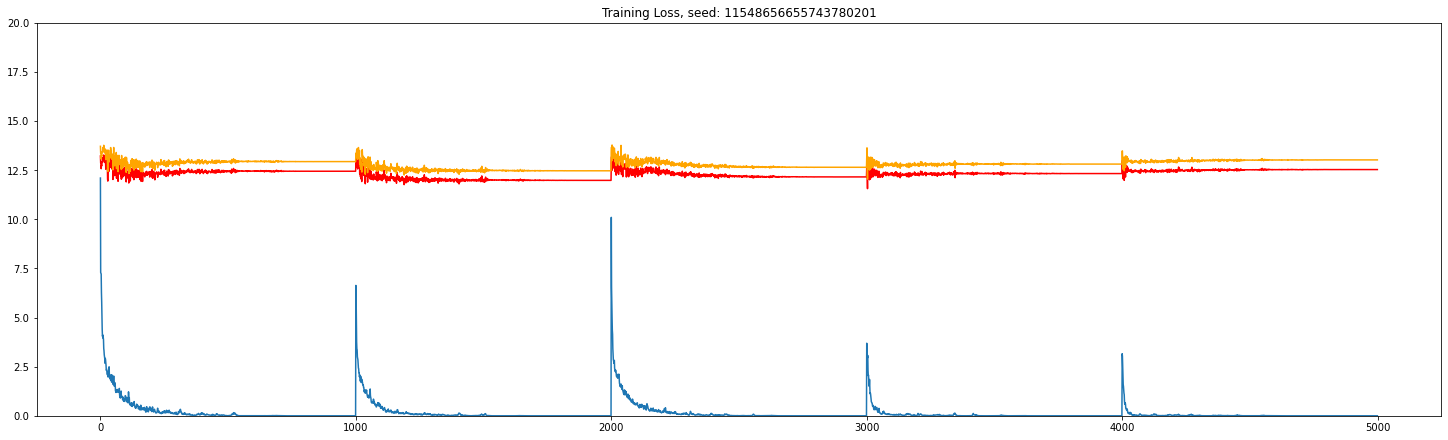

In [3]:
#Training
import time
start = time.perf_counter()

seed = 11548656655743780201
th.manual_seed(seed)
th.cuda.manual_seed(seed)

model = CG_Classifier(num_node_feats=training_dataset.num_node_features).to(device)

b_size = 64
train_dataloader = DataLoader(training_dataset, batch_size=b_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=b_size)

opt = th.optim.Adam(model.parameters(), lr=1e-3)
scheduler = th.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=1000)#, T_mult=2)
model.train()

epochs = 5000

def training_loop(model, learning_rates, train_dataloader, scheduler, opt):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred = model(data)
        loss = F.smooth_l1_loss(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    return epoch_loss

@th.no_grad()
def val_loop(model, val_dataloader):
    model.eval()
    val_loss = 0
    mae_loss = 0
    for i, v_data in enumerate(val_dataloader):
        v_data = v_data.to(device)
        val_pred = model(v_data, model.training)
        v_loss = F.smooth_l1_loss(th.reshape(val_pred, (-1,)), v_data.y, reduction='mean')
        val_loss += v_loss.detach().item()
        mae_l= F.l1_loss(th.reshape(val_pred, (-1,)), v_data.y, reduction="mean")
        mae_loss += mae_l.detach().item()

    val_loss /= (i + 1)
    mae_loss /= (i + 1)
    return val_loss, mae_loss

#training setup
epoch_losses = []
val_losses = []
mae_losses = []
learning_rates = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    learning_rates.append(scheduler.get_last_lr()[0])
    for iter, data in enumerate(train_dataloader):
        data = data.to(device)
        opt.zero_grad()
        pred = model(data, model.training)
        loss = F.smooth_l1_loss(th.reshape(pred, (-1,)), data.y, reduction='mean')
        loss.backward()
        opt.step()
        epoch_loss += loss.detach().item()

    #apply lr changes according to scheme
    scheduler.step()

    epoch_loss /= (iter + 1)
    #epoch_loss = training_loop(model, learning_rates, train_dataloader, scheduler, opt) #what to put into training_loop and what to return?
    epoch_losses.append(epoch_loss)

    val_loss, mae_loss = val_loop(model, val_dataloader)
    val_losses.append(val_loss)
    mae_losses.append(mae_loss)
    
    th.save(model.state_dict(), "pyg_model_data/model_epoch" + str(epoch) + ".pth")
    
    if epoch % 5 == 0:
        print("Epoch {}: Training loss {:.4f}, Validation loss {:.4f}, learning rate: {:.5f}".format(epoch, epoch_loss, val_loss, scheduler.get_last_lr()[0]))
        print(f"\t Validation MAE: {mae_loss:.4f}")
        
end = time.perf_counter()

print(f"Training took {(end - start)/60/60:.2f} hours")
print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")
print(f"Seed used for training was: {th.initial_seed()}")

#plot the training run
figure, ax = plt.subplots(layout="constrained", figsize=(20, 6))
ax.plot(epoch_losses)
ax.plot(val_losses, "r")
ax.plot(mae_losses, "orange")
plt.title(f"Training Loss, seed: {th.initial_seed()}")
ax.set_ybound(lower=0, upper=20)
plt.draw()

In [4]:
#store training run data

file = "2022-04-05_pyg_vec_tag-sage_loss_data.txt"

with open("loss_data/" + file, "w") as fh:
    fh.write(str(epoch_losses) + "\n")
    fh.write(str(val_losses) + "\n")
    fh.write(str(learning_rates) + "\n")
    fh.write(str(mae_losses))

In [11]:
#get training run data

file = "loss_data/2022-04-04_pyg_tag-sage_vector_loss_data.txt"

file_lines = []
with open(file, "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after 50 epochs) {min(val_losses[50:]):.4f} in epoch {val_losses.index(min(val_losses[50:]))}")
print(f"Minimum MAE (after 50 epochs) {min(mae_losses[50:]):.4f} in epoch {mae_losses.index(min(mae_losses[50:]))}")


Minimum Training Loss 0.0001 in epoch 4996
Minimum Validation Loss (after 50 epochs) 12.2119 in epoch 4002
Minimum MAE (after 50 epochs) 12.7011 in epoch 4002


Validation Loss at 1500 is 12.0285
5 before select
['11.9831', '12.0350', '11.9744', '11.9120', '11.9075']
5 after select
['11.9811', '11.9227', '12.0277', '11.8822', '12.0327']
MAE at 1500 is 12.5190


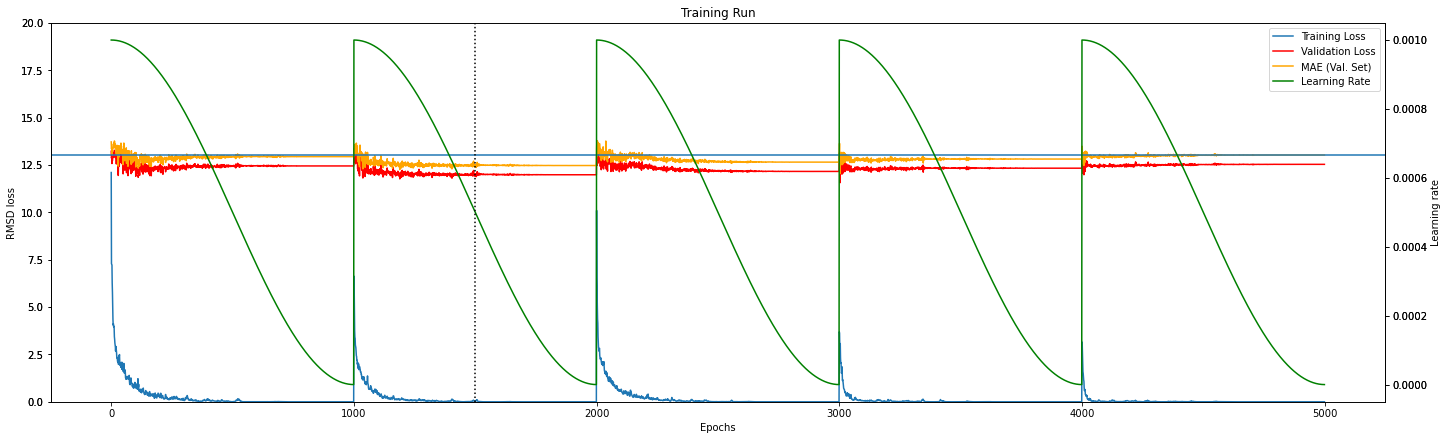

In [14]:
#plot the training run
select = 1500
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print([f"{x:.4f}" for x in val_losses[select-5:select]])
print("5 after select")
print([f"{y:.4f}" for y in val_losses[select+1:select+6]])
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("RMSD loss")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=0, upper=20)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=13)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2)
plt.draw()

In [3]:
#Test Loop
import math
from pyg_classifier.utility import loss_plot, rmsd_scatter, e_rmsd_scatter

@th.no_grad()
def test_loop(model, loader, e_dict, title):
    model.eval()
    max_label = 0
    max_loss = 0
    max_pred = 0
    min_label = math.inf
    min_loss = math.inf
    min_pred = math.inf
    test_losses = []
    true_rmsds = []
    pred_rmsds = []
    energies = []
    trmsds_f_en = []
    prmsds_f_en = []
    for test_graph in loader:
        test_graph = test_graph.to(device)
        test_pred = model(test_graph)
        test_loss = F.l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item() #smooth_l1_loss #(test_pred, test_graph.y).item() #
        test_losses.append(float(test_loss))
        true_rmsds.append(float(test_graph.y))
        pred_rmsds.append(float(test_pred))

        if test_graph.name[0] in e_dict.keys():
            energies.append(e_dict[test_graph.name[0]])
            prmsds_f_en.append(float(test_pred))
            trmsds_f_en.append(float(test_graph.y))
        if test_loss > max_loss:
            max_loss = test_loss
            max_label = test_graph.y
            max_pred = test_pred
        if test_loss < min_loss:
            min_loss = test_loss
            min_label = test_graph.y
            min_pred = test_pred
        if test_pred < 0:
            print(test_graph.y, test_pred)
    
    print(title)
    print(min_label, min_pred, min_loss)
    print(max_label, max_pred, max_loss)
    test_mean = np.mean(test_losses)
    test_std = np.std(test_losses)
    test_fq = np.quantile(test_losses, q = 0.25)
    test_median = np.median(test_losses)
    test_tq = np.quantile(test_losses, q = 0.75)
    print("Mean Test loss: \t {:.4f}".format(test_mean))
    print("Std. Dev. of Test loss:  {:.4f}".format(test_std))
    print("Min loss: \t\t {:.4f}".format(min(test_losses)))
    print("First Quantile: \t {:.4f}".format(test_fq))
    print("Median: \t\t {:.4f}".format(test_median))
    print("Third Quantile: \t {:.4f}".format(test_tq))
    print("Max Loss: \t\t {:.4f}".format(max(test_losses)))
    
    loss_plot(test_losses, test_fq, test_median, test_tq, title + ", Sorted Test Losses")
    rmsd_scatter(pred_rmsds, true_rmsds, title)
    e_rmsd_scatter(energies, trmsds_f_en, title + ", True RMSDs vs Energy")
    e_rmsd_scatter(energies, prmsds_f_en, title + ", Predicted RMSDs vs Energy")
    return energies, trmsds_f_en, prmsds_f_en

Test Set
tensor([27.1360], device='cuda:0') tensor([[27.1791]], device='cuda:0') 0.04308509826660156
tensor([0.0170], device='cuda:0') tensor([[29.6257]], device='cuda:0') 29.60869598388672
Mean Test loss: 	 11.7219
Std. Dev. of Test loss:  7.8968
Min loss: 		 0.0431
First Quantile: 	 4.9513
Median: 		 10.5714
Third Quantile: 	 17.4216
Max Loss: 		 29.6087


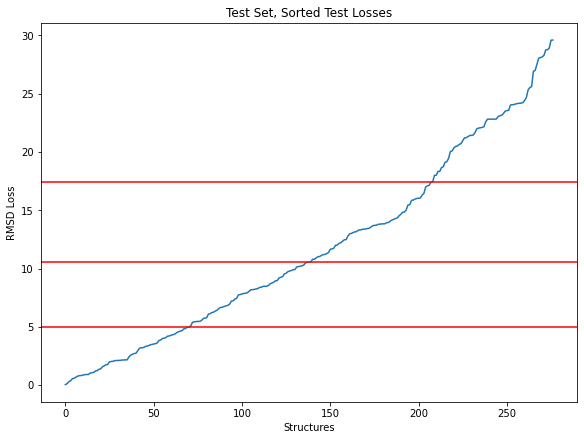

LinregressResult(slope=0.3430007894194401, intercept=9.226443909534819, rvalue=0.17326704078622737, pvalue=0.003820579870080461, stderr=0.11756928466523249, intercept_stderr=2.706483431964094)


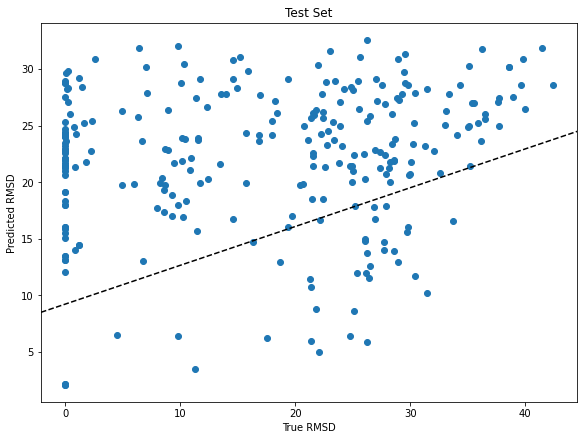

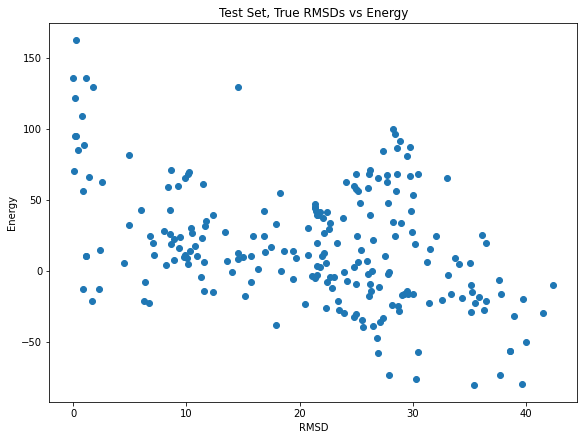

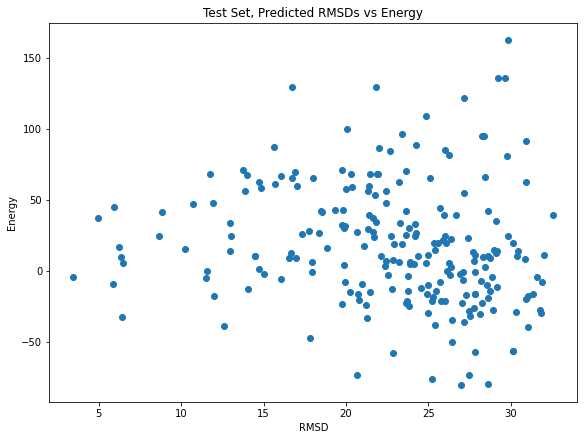

5S and tRNA Test Set
tensor([0.], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([0.], device='cuda:0') tensor([[32.8511]], device='cuda:0') 32.85106658935547
Mean Test loss: 	 5.5441
Std. Dev. of Test loss:  5.7821
Min loss: 		 0.0000
First Quantile: 	 1.6901
Median: 		 3.6757
Third Quantile: 	 6.9816
Max Loss: 		 32.8511


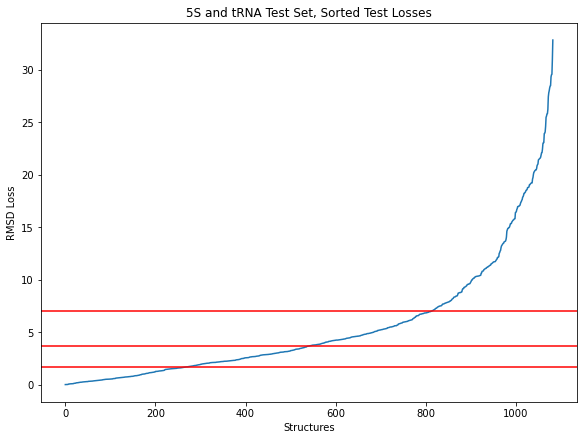

LinregressResult(slope=0.7255899752981544, intercept=2.7304879538098152, rvalue=0.5481813782389791, pvalue=5.647919993127315e-86, stderr=0.03367031127883411, intercept_stderr=0.6516599003690118)


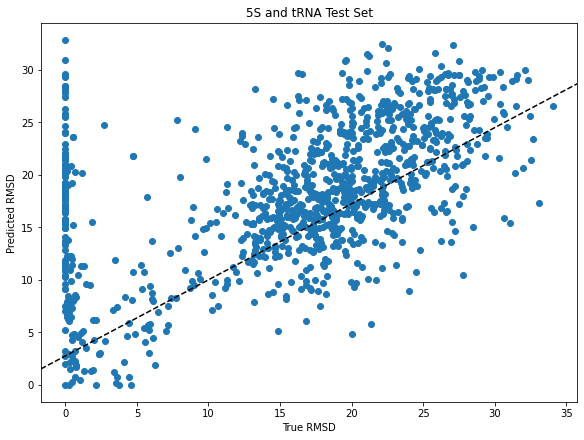

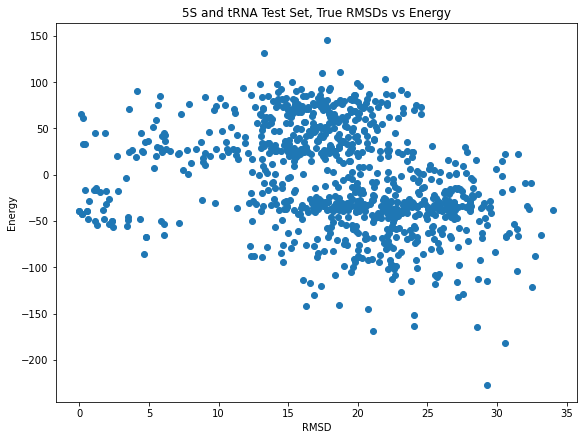

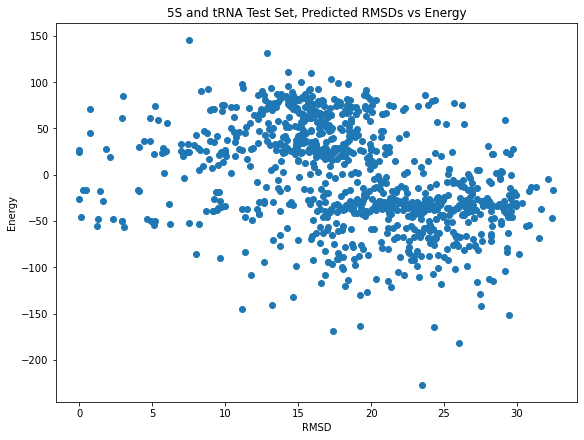

Training Set
tensor([0.], device='cuda:0') tensor([[0.]], device='cuda:0') 0.0
tensor([25.6700], device='cuda:0') tensor([[26.1820]], device='cuda:0') 0.5120315551757812
Mean Test loss: 	 0.0823
Std. Dev. of Test loss:  0.0669
Min loss: 		 0.0000
First Quantile: 	 0.0297
Median: 		 0.0677
Third Quantile: 	 0.1138
Max Loss: 		 0.5120


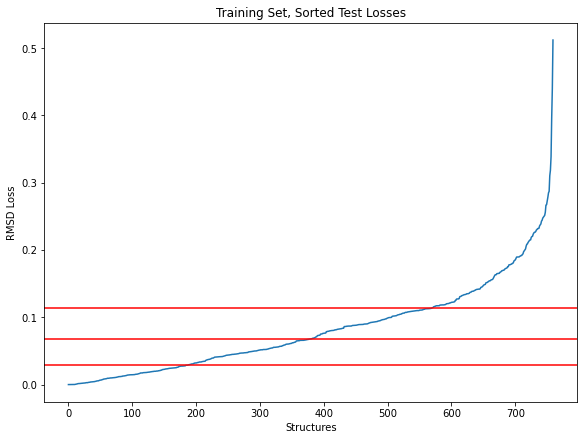

LinregressResult(slope=1.0027580121392132, intercept=-0.03666367702377471, rvalue=0.9999380073026092, pvalue=0.0, stderr=0.00040557109522214275, intercept_stderr=0.008148908722609855)


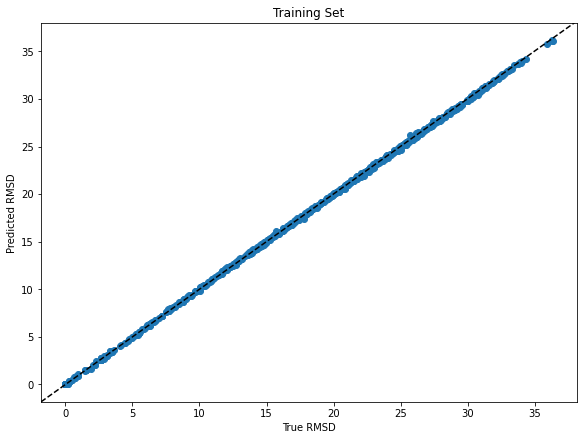

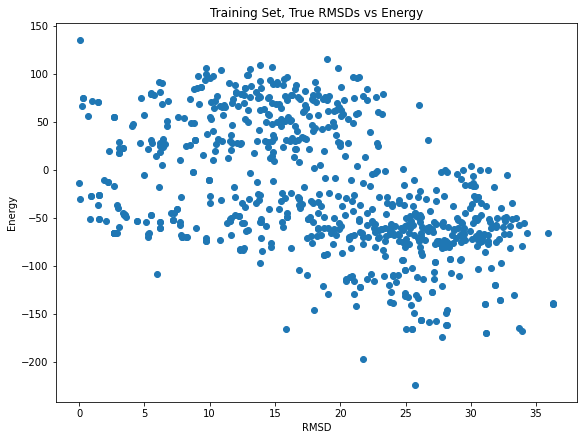

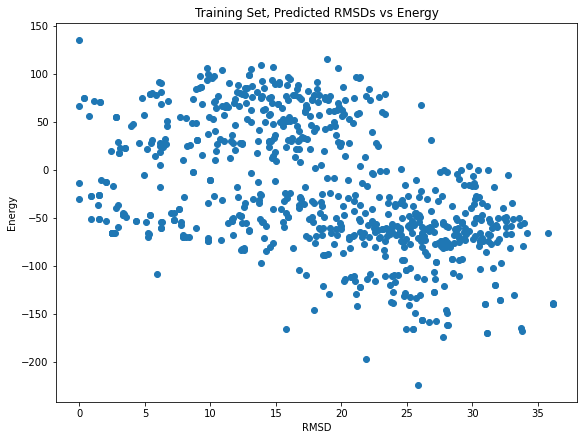

Validation Set
tensor([15.4050], device='cuda:0') tensor([[15.4195]], device='cuda:0') 0.014538764953613281
tensor([61.9850], device='cuda:0') tensor([[13.3980]], device='cuda:0') 48.58701705932617
Mean Test loss: 	 12.9330
Std. Dev. of Test loss:  9.7552
Min loss: 		 0.0145
First Quantile: 	 4.4036
Median: 		 11.5605
Third Quantile: 	 19.3538
Max Loss: 		 48.5870


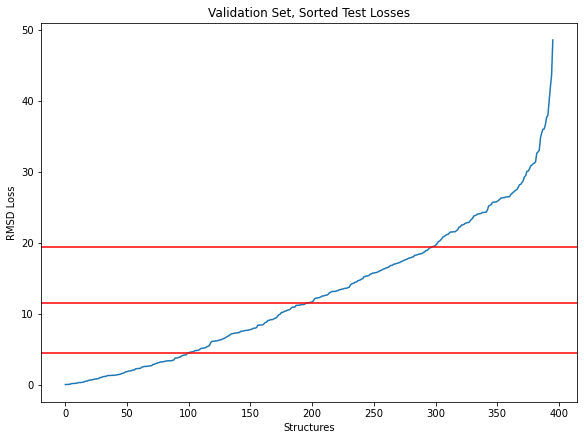

LinregressResult(slope=0.4494195453650741, intercept=13.377656413696066, rvalue=0.16290652857270618, pvalue=0.001140690801624227, stderr=0.13712755660616582, intercept_stderr=3.1146157464308506)


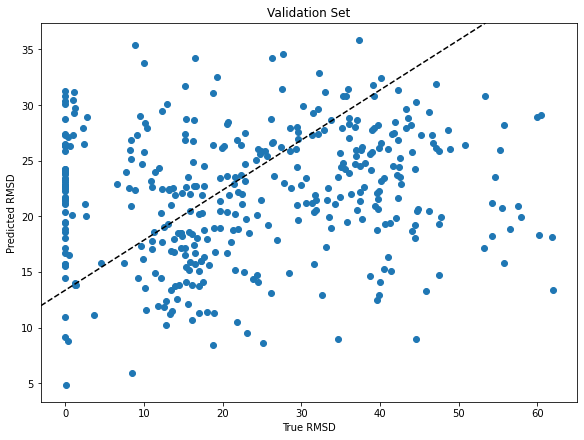

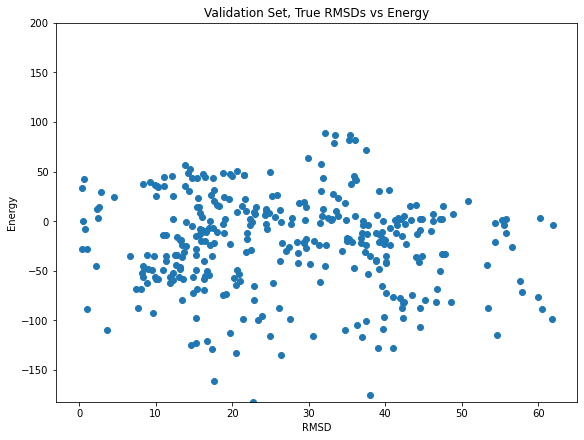

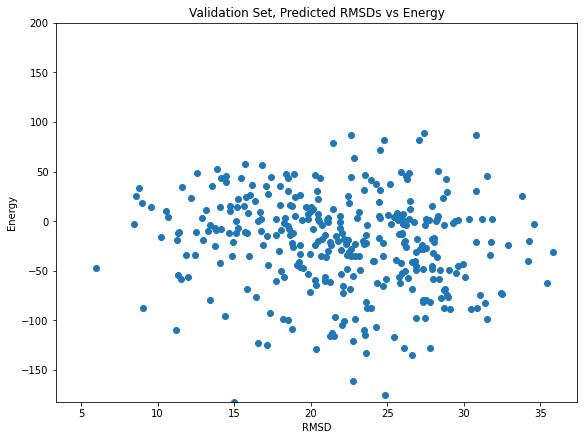

LinregressResult(slope=0.8147747595823599, intercept=4.136226631017118, rvalue=0.6161661052553348, pvalue=5.47426402079631e-233, stderr=0.02207950909245704, intercept_stderr=0.460709973358912)


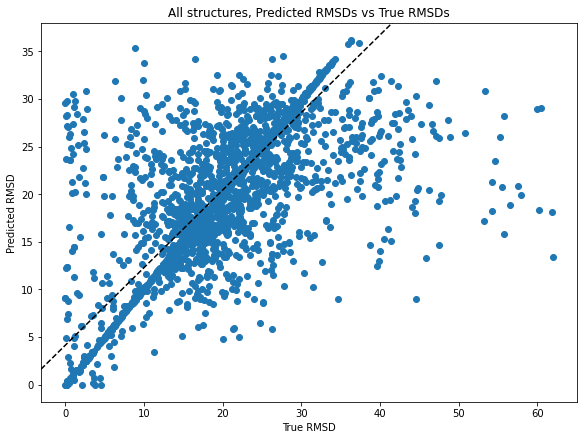

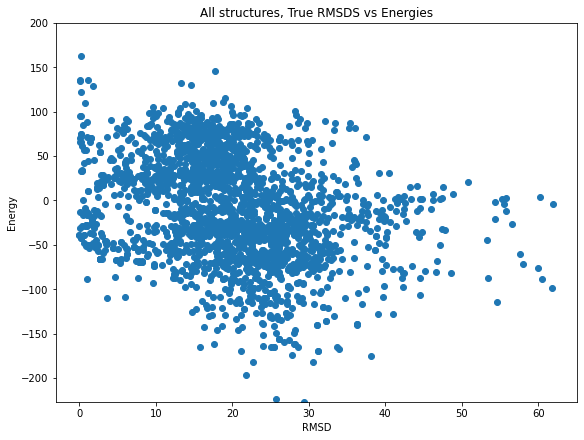

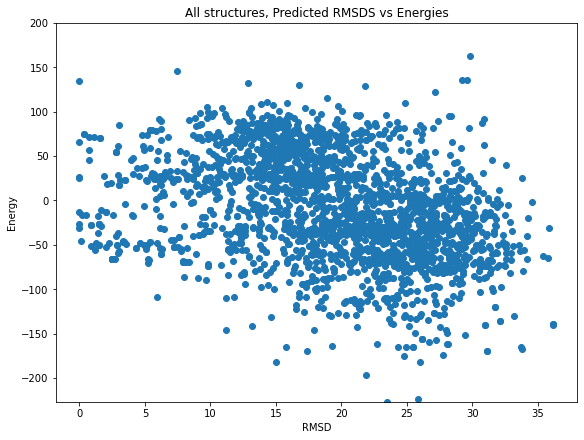

In [4]:
#Test
import math
from pyg_classifier.utility import get_energy_dict

if "model" not in globals():
    model = CG_Classifier(num_node_feats=training_dataset.num_node_features)

train_loader = DataLoader(training_dataset)
val_loader = DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)
st_test_dataloader = DataLoader(st_test_dataset)

model.to(device)
model.load_state_dict(th.load("pyg_model_data/2022-04-04_model_pyg_k3v_tag-sage_ep4235.pth"))

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs = test_loop(model, loader, e_dict, title)
    energy_l += en
    true_rmsd_l += trs
    pred_rmsd_l += prs

rmsd_scatter(pred_rmsd_l, true_rmsd_l, "All structures, Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures, True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures, Predicted RMSDS vs Energies")
        

In [8]:
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k)

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k)

LinregressResult(slope=0.22619680457148317, intercept=17.920967320598624, rvalue=0.2363155467102189, pvalue=7.136542018952412e-05, stderr=0.056085353906718705, intercept_stderr=1.4077468345523596)


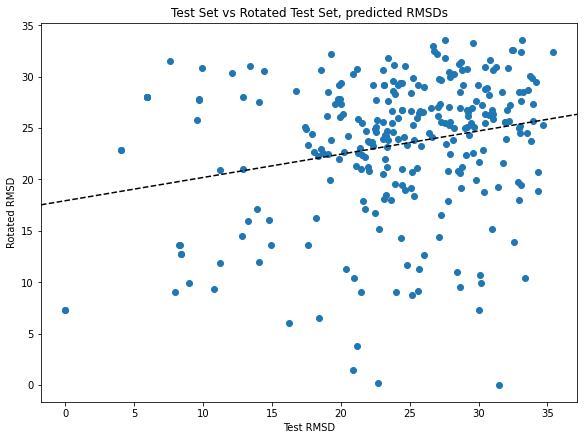

LinregressResult(slope=0.5988497693306161, intercept=4.250056750538049, rvalue=0.6189841848590241, pvalue=1.092022844456554e-30, stderr=0.04582102408773682, intercept_stderr=0.6684341730625635)


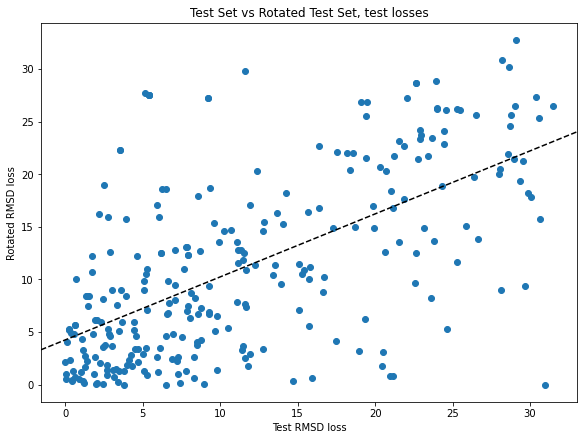

LinregressResult(slope=0.24005414705155684, intercept=17.180721064931213, rvalue=0.3137636196402501, pvalue=3.608654449950643e-26, stderr=0.022094758771126377, intercept_stderr=0.45591684887883793)


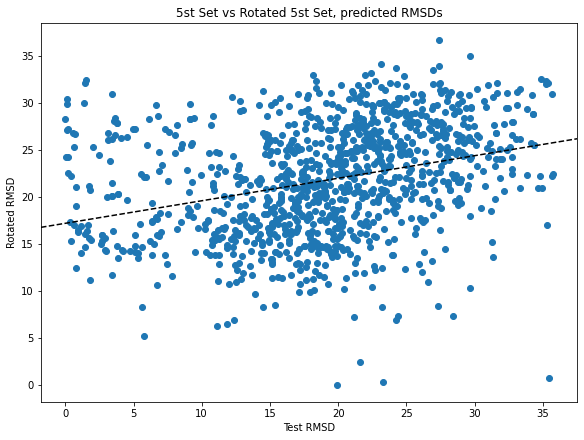

LinregressResult(slope=0.6350016858660101, intercept=4.271784551273958, rvalue=0.5476401453577913, pvalue=8.938411973529025e-86, stderr=0.029508271830188077, intercept_stderr=0.25246535261363107)


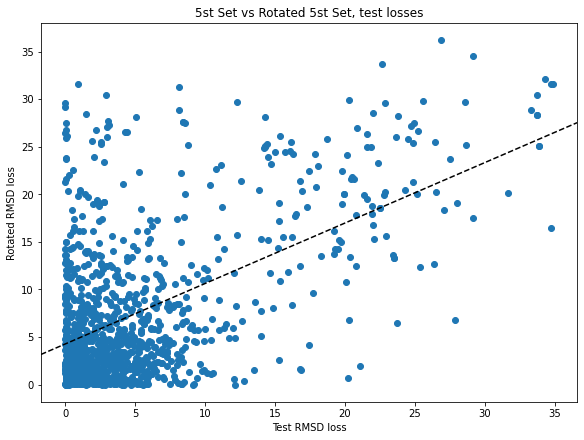

In [15]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset)
fst_rot_dataloader = DataLoader(fst_rot_dataset)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred = model(test_graph)
                test_loss = F.smooth_l1_loss(th.reshape(test_pred, (-1,)), test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")